<a href="https://colab.research.google.com/github/Joana-Mansa/brain_tumor_segmentations_and_classification/blob/deep_learning_/brain_tumor_transfer_learning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. 0 Deep Learning
1. Classification using vgg16 and ResNet Transfer Learning Approach
2. Tumor Segmentation using the U-Net Architecture

In [ ]:
%matplotlib inline

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import vgg16
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [2]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# define your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Preparation

In [ ]:
# the folder had both images and their masks
# this code was meant to only make use of the images and ignore their masks

import os
from torchvision import datasets
from torchvision import transforms

import os
from torchvision import datasets

class CustomImageFolder(datasets.ImageFolder):
    def make_dataset(self, directory, class_to_idx, extensions=None, is_valid_file=None):
        instances = []
        directory = os.path.expanduser(directory)
        both_none = extensions is None and is_valid_file is None
        if both_none:
            raise ValueError("Both extensions and is_valid_file cannot be None")

        if extensions is not None:
            def is_valid_file(x):
                return x.lower().endswith(extensions)

        # Define the specific folder name for images
        image_folder_name = 'images'

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class, image_folder_name)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if is_valid_file(path):
                        item = path, class_index
                        instances.append(item)
        return instances


### Data Preparation

In [4]:
# Define transformations for the test set
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/train_test_dataset/'

# load the training dataset
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms['train'])
# split the training data into training and validation set
train_size = int(0.8* len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# applying the validation transformations to the validation subset
val_dataset.dataset.transform = data_transforms['val']

# loading the test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms['test'])

# Create DataLoaders for training, validation, and test sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}
class_names = train_dataset.dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualize a few images
----------------------------------
Let's visualize a few training images so as to understand the data
augmentations.



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Classes: tensor([2, 0, 2, 0, 0, 2, 1, 1])
Class names length 3


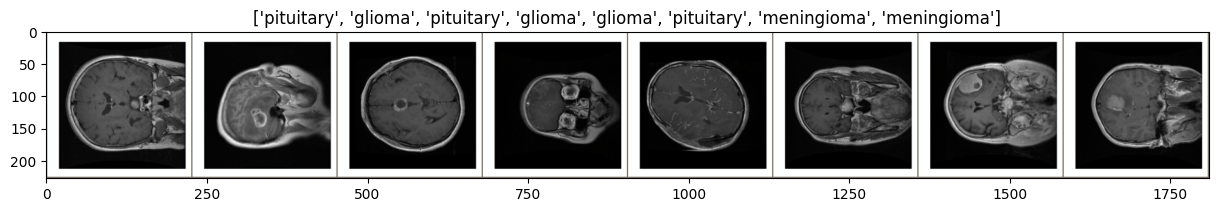

In [5]:
def imshow(inp, title=None, fig_size=(10, 10)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# class_names = ['class0', 'class1', 'class2']
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# debug prints
print("Classes:", classes)
print("Class names length", len(class_names))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# ensure all class indices are valid
valid_classes = [x for x in classes if x < len(class_names)]
if len(valid_classes) != len(classes):
    print("Warning: Some class indices are out of bounds")

imshow(out, title=[class_names[x] for x in classes], fig_size=(15, 15))


### 3.1.0 Classification - VGG16

### VGG-16 as a Feature Extractor

Load Pre-trained VGG16 and Modify the classifier



In [6]:
model = models.vgg16(pretrained=True)

# freezes the feature extractor parameter
for param in model.features.parameters():
  param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.4MB/s]


In [7]:
# modify the classifier


# gets input features of the last layer
# 6 represents the index of the layer in the classifier sequence of vgg16 in PyTorch
# (classifier): Sequential(
    # (0): Linear(in_features=25088, out_features=4096, bias=True)
    # (1): ReLU(inplace=True)
    # (2): Dropout(p=0.5, inplace=False)
    # (3): Linear(in_features=4096, out_features=4096, bias=True)
    # (4): ReLU(inplace=True)
    # (5): Dropout(p=0.5, inplace=False)
    # (6): Linear(in_features=4096, out_features=1000, bias=True)  # This is the layer we want to change)
# the 6th layer is responsible for producing the output logits for each class (1000)
# change the output to the number of the classes being worked on
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 3)

model = model.to(device)

### Define the Loss Function and Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()

# only parameters of the final layer are being optimised
optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Training the model


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



## Training the Model

In [11]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.8510 Acc: 0.6960
val Loss: 0.4434 Acc: 0.8436

Epoch 2/30
----------
train Loss: 0.8247 Acc: 0.7494
val Loss: 0.6273 Acc: 0.7907

Epoch 3/30
----------
train Loss: 0.7609 Acc: 0.7649
val Loss: 0.6030 Acc: 0.8282

Epoch 4/30
----------
train Loss: 0.7674 Acc: 0.7852
val Loss: 0.4708 Acc: 0.8612

Epoch 5/30
----------
train Loss: 0.7989 Acc: 0.7836
val Loss: 0.5248 Acc: 0.8414

Epoch 6/30
----------
train Loss: 0.7755 Acc: 0.7891
val Loss: 0.4819 Acc: 0.8480

Epoch 7/30
----------
train Loss: 0.6372 Acc: 0.8084
val Loss: 0.3955 Acc: 0.8722

Epoch 8/30
----------
train Loss: 0.6118 Acc: 0.8128
val Loss: 0.3662 Acc: 0.8700

Epoch 9/30
----------
train Loss: 0.5841 Acc: 0.8084
val Loss: 0.3646 Acc: 0.8789

Epoch 10/30
----------
train Loss: 0.5769 Acc: 0.8128
val Loss: 0.3627 Acc: 0.8833

Epoch 11/30
----------
train Loss: 0.5691 Acc: 0.8210
val Loss: 0.3532 Acc: 0.8855

Epoch 12/30
----------
train Loss: 0.5331 Acc: 0.8166
val Loss: 0.3509 Acc: 0.8877

Epoch 13/30
----------


In [12]:
# save the trained model's state dictionary
torch.save(model.state_dict(), 'vgg16_model.pth')

In [13]:
# load the trained model
model.load_state_dict(torch.load('/content/vgg16_model.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Visualizing the model predictions
----------------------------------

Generic function to display predictions for a few images




In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

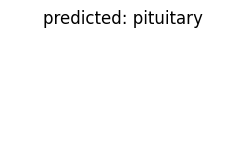

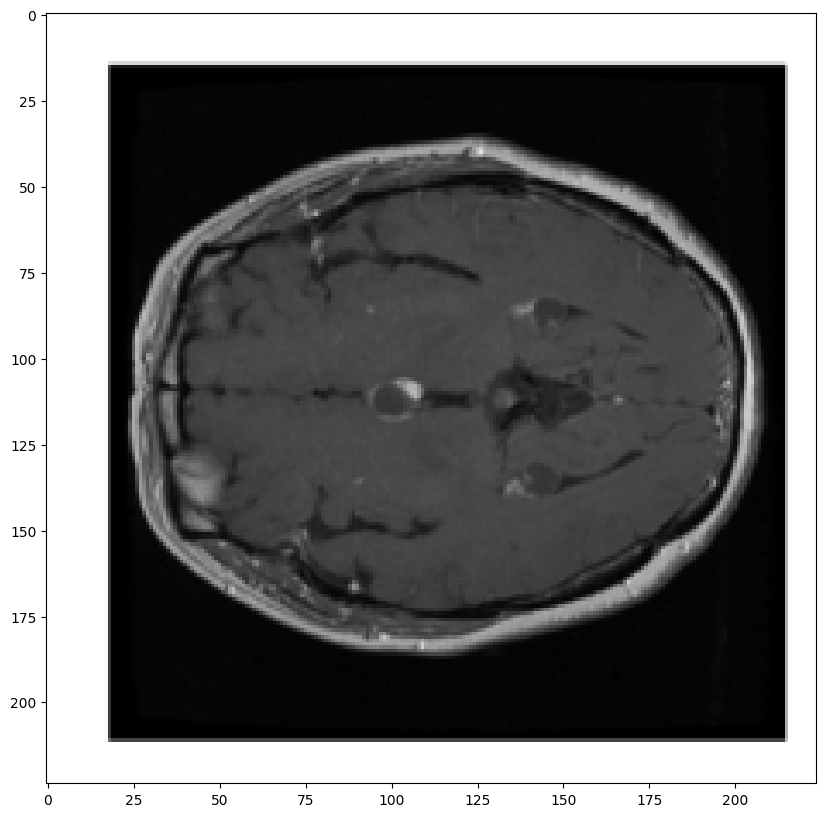

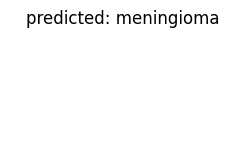

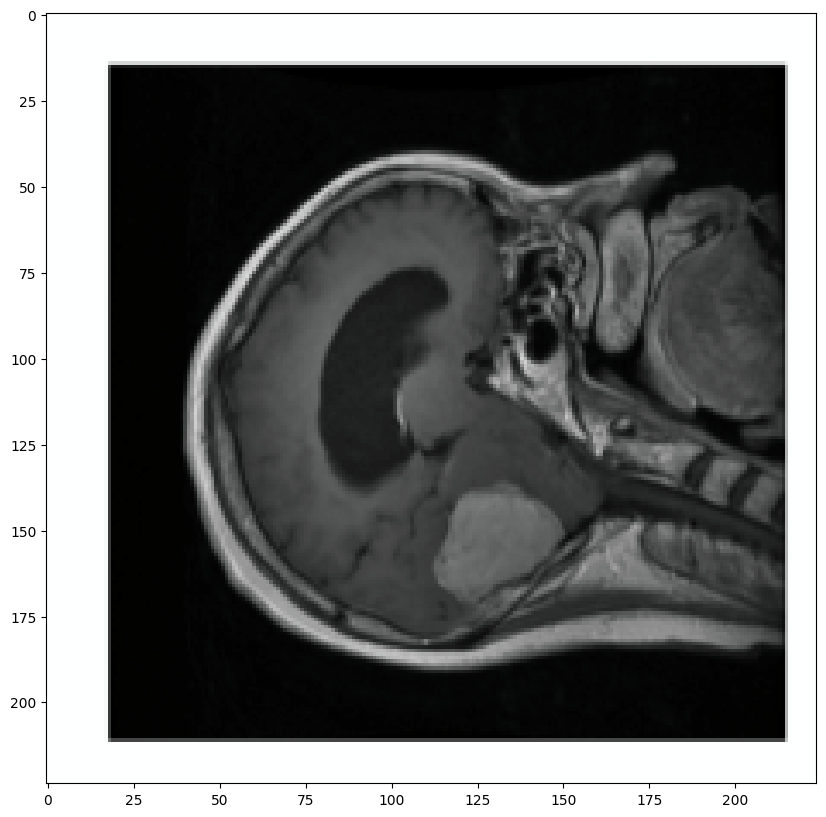

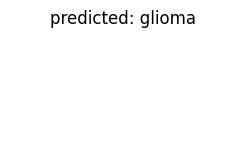

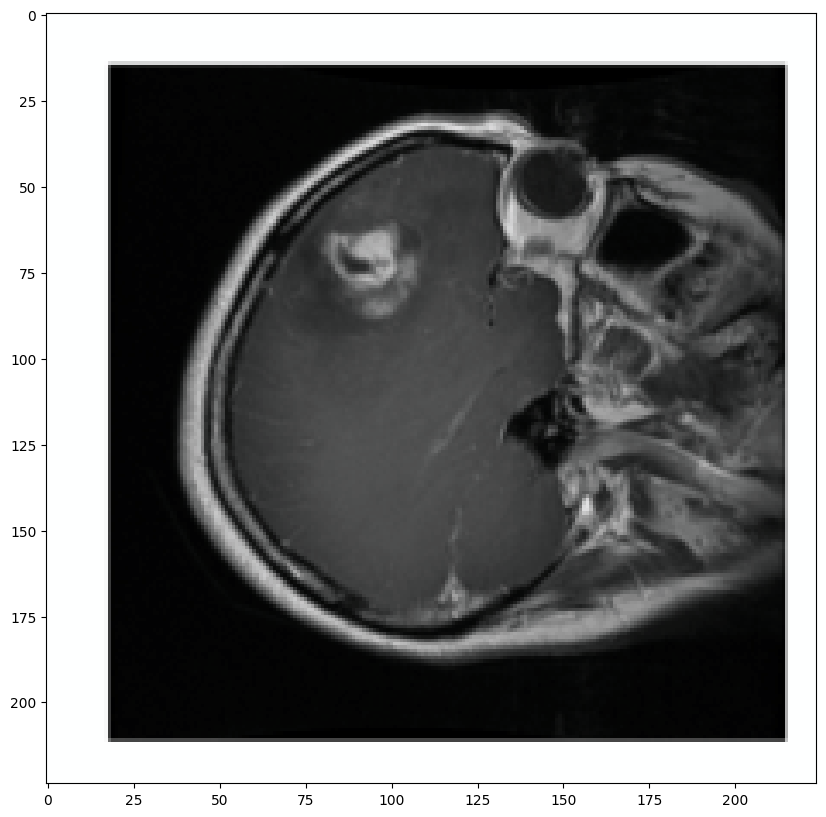

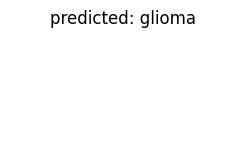

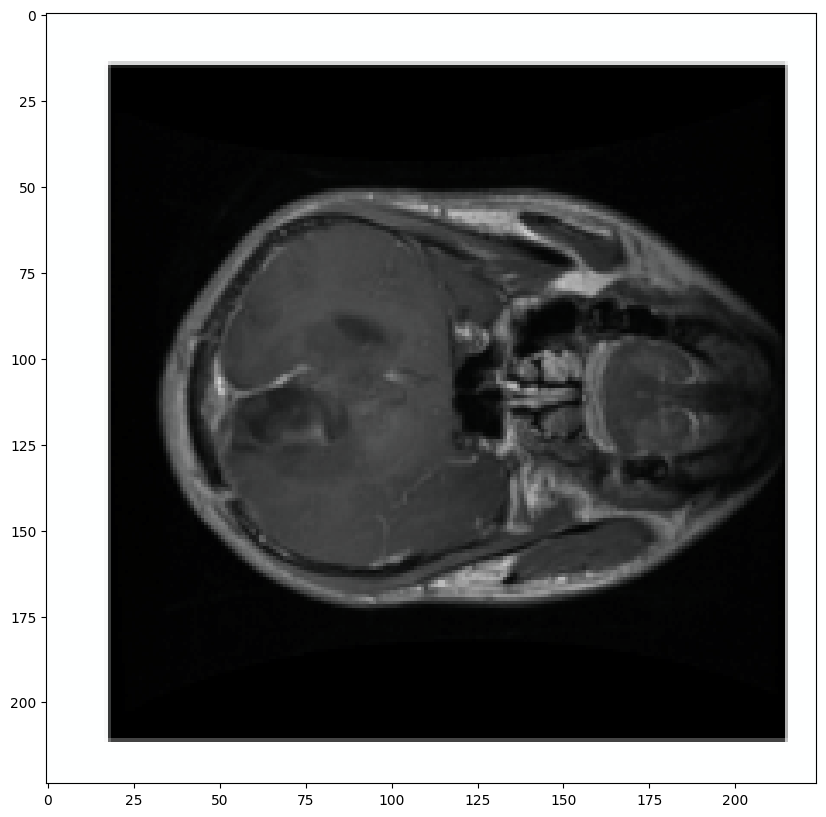

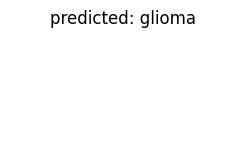

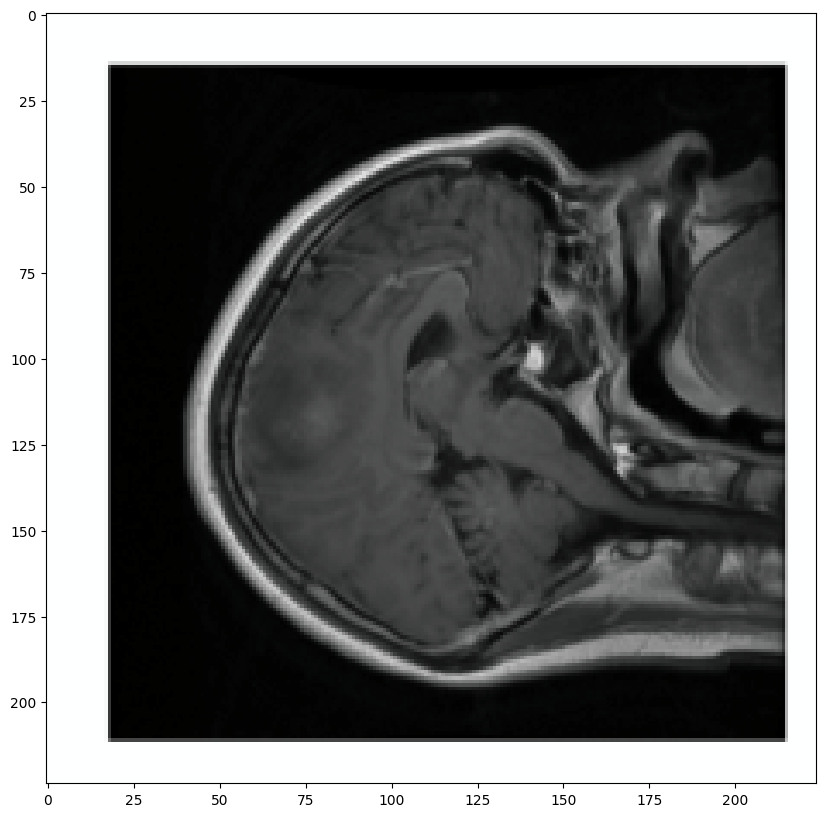

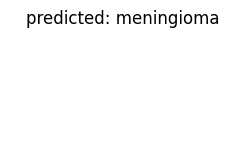

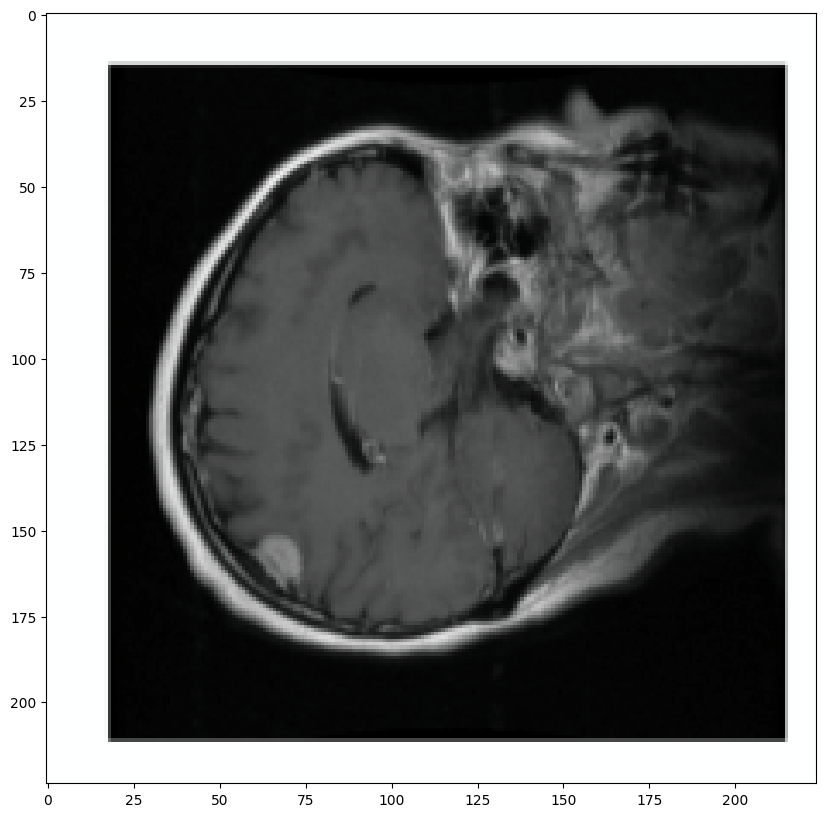

In [15]:
visualize_model(model)

### Evaluating the VGG16 Model

In [16]:
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

accuracy = correct / total
print(f"Test accuracy: {accuracy}")


Test accuracy: 0.8729641693811075


Accuracy of the vgg16 model is 87% on the test data

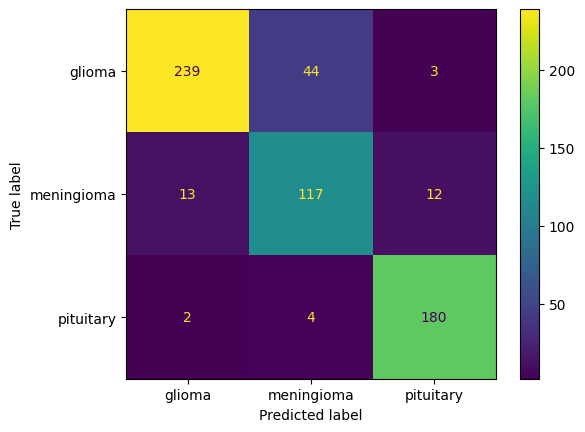

In [17]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [18]:
# classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      glioma       0.94      0.84      0.89       286
  meningioma       0.71      0.82      0.76       142
   pituitary       0.92      0.97      0.94       186

    accuracy                           0.87       614
   macro avg       0.86      0.88      0.86       614
weighted avg       0.88      0.87      0.87       614



1. Precision answers, 'what proportion of the predicted positives is actually correct?'. Focuses on the correctness of the positive predictions.

2. Recall answers, 'what proportion of the actual positives is correctly identified?'. Focuses on the model's ability to find all relevant positive instances in the dataset

3. F1- score - weighted average of precision and recall. the dataset is imbalanced, Glioma had 1426 orignal samples, meningioma 708, pituitary 930

4. Support - number of images belonging to the classes

5. Accuracy: ratio of correctly predicted samples to the total number of samples

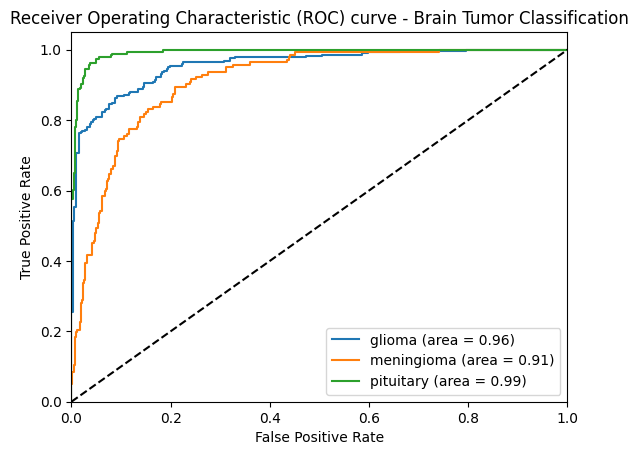

In [19]:
# initialising dictionaries
# false positive rate (FPR)
fpr = {}

# True Positive Rate (TPR)
tpr = {}

# ROC AUC values for each class
roc_auc = {}


# convert all the labels and probabilities to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# calculate the FPR, TPR, ROC AUC for each class
for i in range(3):

  # compute ROC curve for each class
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])

    # compute area under the curve
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for all the classes
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

# plot a diagonal line representing a random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--')

# set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve - Brain Tumor Classification')
plt.legend(loc='lower right')
plt.show()



Pituitary (green) - closer to the top left corner, suggests high sensitivity and low false positive rate

meningioma (orange) - compared to the last class (glioma) it has a slightly high sensitivity

In [20]:
# function to calculate the sensitivity and specificity for the classes
def calculate_sensitivity_specificity(cm, class_index):

  # true positives
    tp = cm[class_index, class_index]

    # false negatives
    fn = cm[class_index, :].sum() - tp

    # false positives
    fp = cm[:, class_index].sum() - tp

    # true negatives
    tn = cm.sum() - (tp + fn + fp)

    # sensitivity (Recall) - actual positibes correctly identified
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0

    # proportion of actual negatives that are correctly identified
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    return sensitivity, specificity

# list to store the sensitivities and specificities for the classes
sensitivities = []
specificities = []

# calculate sensitivity and specificity for each class
for i in range(3):
    sensitivity, specificity = calculate_sensitivity_specificity(cm, i)
    sensitivities.append(sensitivity)
    specificities.append(specificity)


# Print the class names along with their sensitivities and specificities
for i in range(3):
    print(f'Class: {class_names[i]}')
    print(f'  Sensitivity: {sensitivities[i]:.2f}')
    print(f'  Specificity: {specificities[i]:.2f}')

Class: glioma
  Sensitivity: 0.84
  Specificity: 0.95
Class: meningioma
  Sensitivity: 0.82
  Specificity: 0.90
Class: pituitary
  Sensitivity: 0.97
  Specificity: 0.96


### VGG-16 as a Fine-Tuner

In [21]:
model_tune = models.vgg16(pretrained=True)

# unfreeze all the layers
for param in model_tune.features.parameters():
  param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# modify the classifier


# gets input features of the last layer
# 6 represents the index of the layer in the classifier sequence of vgg16 in PyTorch
# (classifier): Sequential(
    # (0): Linear(in_features=25088, out_features=4096, bias=True)
    # (1): ReLU(inplace=True)
    # (2): Dropout(p=0.5, inplace=False)
    # (3): Linear(in_features=4096, out_features=4096, bias=True)
    # (4): ReLU(inplace=True)
    # (5): Dropout(p=0.5, inplace=False)
    # (6): Linear(in_features=4096, out_features=1000, bias=True)  # This is the layer we want to change)
# the 6th layer is responsible for producing the output logits for each class (1000)
# change the output to the number of the classes being worked on
num_ftrs = model_tune.classifier[6].in_features
model_tune.classifier[6] = nn.Linear(num_ftrs, 3)

model_tune = model_tune.to(device)

I had the same accuracy as when i used vgg16 as an extractor, I lowered the lr parameter to 10e^-4 to see if it would make any difference

In [30]:
criterion = nn.CrossEntropyLoss()



# only parameters of the final layer are being optimised
optimizer = optim.SGD(model_tune.classifier[6].parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
model_tune = train_model(model_tune, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5146 Acc: 0.8221
val Loss: 0.3513 Acc: 0.8789

Epoch 2/30
----------
train Loss: 0.5256 Acc: 0.8128
val Loss: 0.3291 Acc: 0.8921

Epoch 3/30
----------
train Loss: 0.5139 Acc: 0.8238
val Loss: 0.3277 Acc: 0.8943

Epoch 4/30
----------
train Loss: 0.4762 Acc: 0.8271
val Loss: 0.3249 Acc: 0.8899

Epoch 5/30
----------
train Loss: 0.5124 Acc: 0.8227
val Loss: 0.3535 Acc: 0.8877

Epoch 6/30
----------
train Loss: 0.4930 Acc: 0.8232
val Loss: 0.3276 Acc: 0.8877

Epoch 7/30
----------
train Loss: 0.4378 Acc: 0.8431
val Loss: 0.3262 Acc: 0.8877

Epoch 8/30
----------
train Loss: 0.4861 Acc: 0.8304
val Loss: 0.3272 Acc: 0.8899

Epoch 9/30
----------
train Loss: 0.4746 Acc: 0.8276
val Loss: 0.3235 Acc: 0.8899

Epoch 10/30
----------
train Loss: 0.4820 Acc: 0.8354
val Loss: 0.3228 Acc: 0.8877

Epoch 11/30
----------
train Loss: 0.4509 Acc: 0.8354
val Loss: 0.3218 Acc: 0.8877

Epoch 12/30
----------
train Loss: 0.4520 Acc: 0.8365
val Loss: 0.3222 Acc: 0.8877

Epoch 13/30
----------


In [32]:
torch.save(model_tune.state_dict(), 'vgg16_model_tuner_lr.pth')

In [33]:
# load the trained model
model.load_state_dict(torch.load('/content/vgg16_model_tuner_lr.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
# checking the accuracy of vgg16 as a fine-tuner model
correct = 0
total = 0
tuner_labels = []
tuner_preds = []
tuner_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_tune(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        tuner_labels.extend(labels.cpu().numpy())
        tuner_preds.extend(preds.cpu().numpy())
        tuner_probs.extend(outputs.cpu().numpy())

accuracy = correct / total
print(f"Test accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8697068403908795


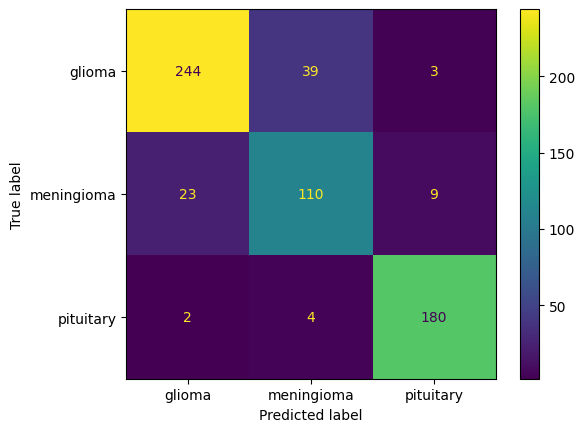

In [35]:
# confusion matrix for vgg16 as a fine-tuning model
cm = confusion_matrix(tuner_labels, tuner_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [36]:
# classification Report
report = classification_report(tuner_labels, tuner_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      glioma       0.91      0.85      0.88       286
  meningioma       0.72      0.77      0.75       142
   pituitary       0.94      0.97      0.95       186

    accuracy                           0.87       614
   macro avg       0.85      0.87      0.86       614
weighted avg       0.87      0.87      0.87       614



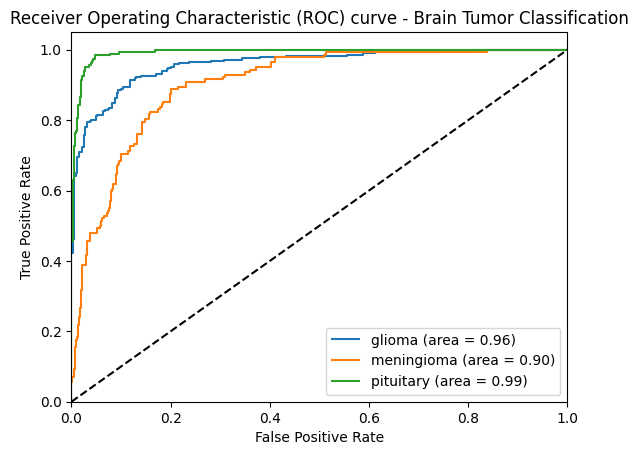

In [39]:
# ROC curve for the vgg16 as a fine-tuning model
# initialising dictionaries
# false positive rate (FPR)
fpr = {}

# True Positive Rate (TPR)
tpr = {}

# ROC AUC values for each class
roc_auc = {}


# convert all the labels and probabilities to numpy arrays
tuner_labels = np.array(tuner_labels)
tuner_probs = np.array(tuner_probs)

# calculate the FPR, TPR, ROC AUC for each class
for i in range(3):

  # compute ROC curve for each class
    fpr[i], tpr[i], _ = roc_curve(tuner_labels == i, tuner_probs[:, i])

    # compute area under the curve
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for all the classes
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

# plot a diagonal line representing a random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--')

# set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve - Brain Tumor Classification')
plt.legend(loc='lower right')
plt.show()



### Using a ResNet Model as a Fine Tuner




In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)
# inputs, labels = inputs.to(device), labels.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


#### Train and evaluate
----------------------------------

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [41]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.war

train Loss: 0.4605 Acc: 0.8018
val Loss: 0.3746 Acc: 0.8480

Epoch 2/30
----------
train Loss: 0.2118 Acc: 0.9279
val Loss: 0.3536 Acc: 0.8943

Epoch 3/30
----------
train Loss: 0.1623 Acc: 0.9356
val Loss: 0.2644 Acc: 0.9163

Epoch 4/30
----------
train Loss: 0.0887 Acc: 0.9692
val Loss: 0.1204 Acc: 0.9581

Epoch 5/30
----------
train Loss: 0.0866 Acc: 0.9708
val Loss: 0.0688 Acc: 0.9780

Epoch 6/30
----------
train Loss: 0.0283 Acc: 0.9901
val Loss: 0.0589 Acc: 0.9802

Epoch 7/30
----------
train Loss: 0.0251 Acc: 0.9945
val Loss: 0.0578 Acc: 0.9736

Epoch 8/30
----------
train Loss: 0.0133 Acc: 0.9967
val Loss: 0.0754 Acc: 0.9802

Epoch 9/30
----------
train Loss: 0.0169 Acc: 0.9956
val Loss: 0.0623 Acc: 0.9824

Epoch 10/30
----------
train Loss: 0.0159 Acc: 0.9967
val Loss: 0.0516 Acc: 0.9780

Epoch 11/30
----------
train Loss: 0.0158 Acc: 0.9950
val Loss: 0.0676 Acc: 0.9802

Epoch 12/30
----------
train Loss: 0.0202 Acc: 0.9934
val Loss: 0.0677 Acc: 0.9824

Epoch 13/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


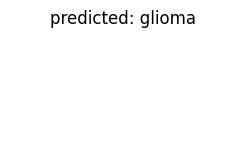

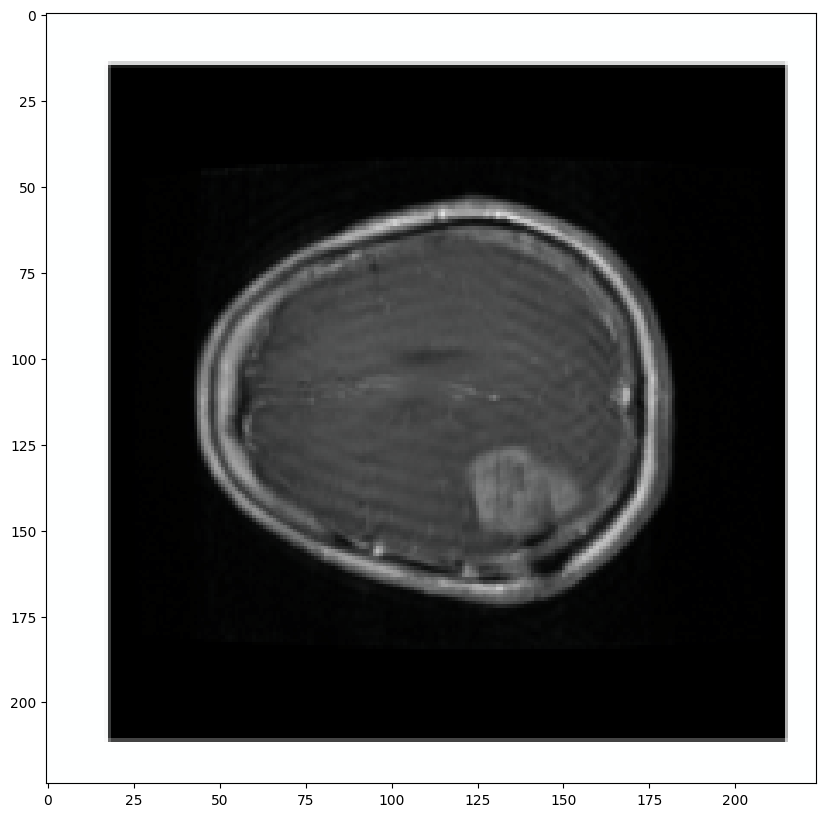

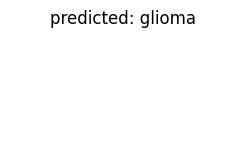

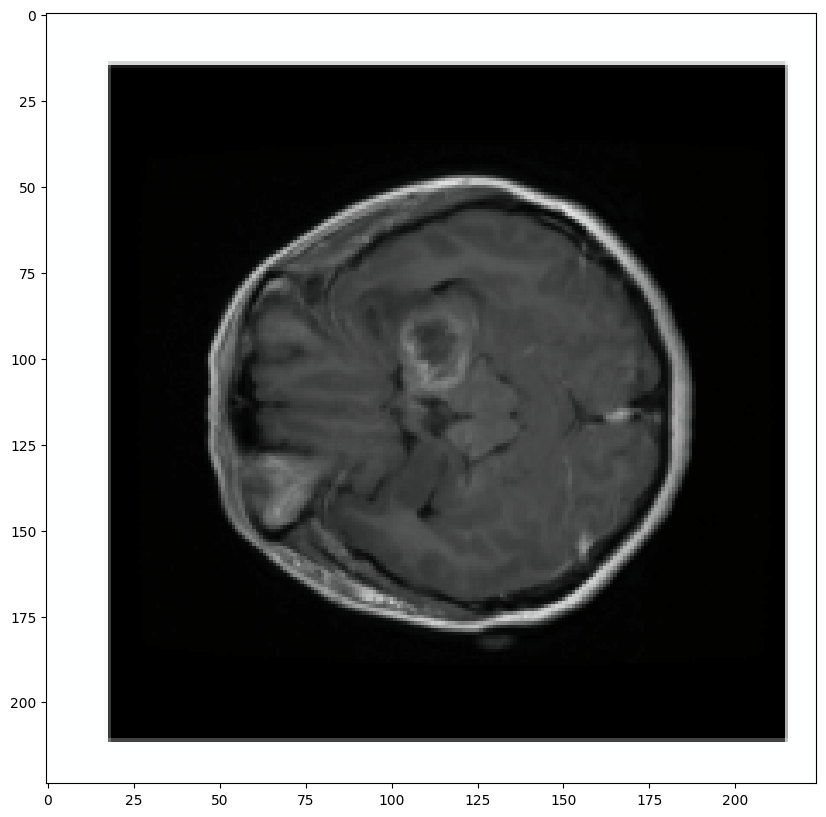

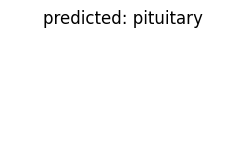

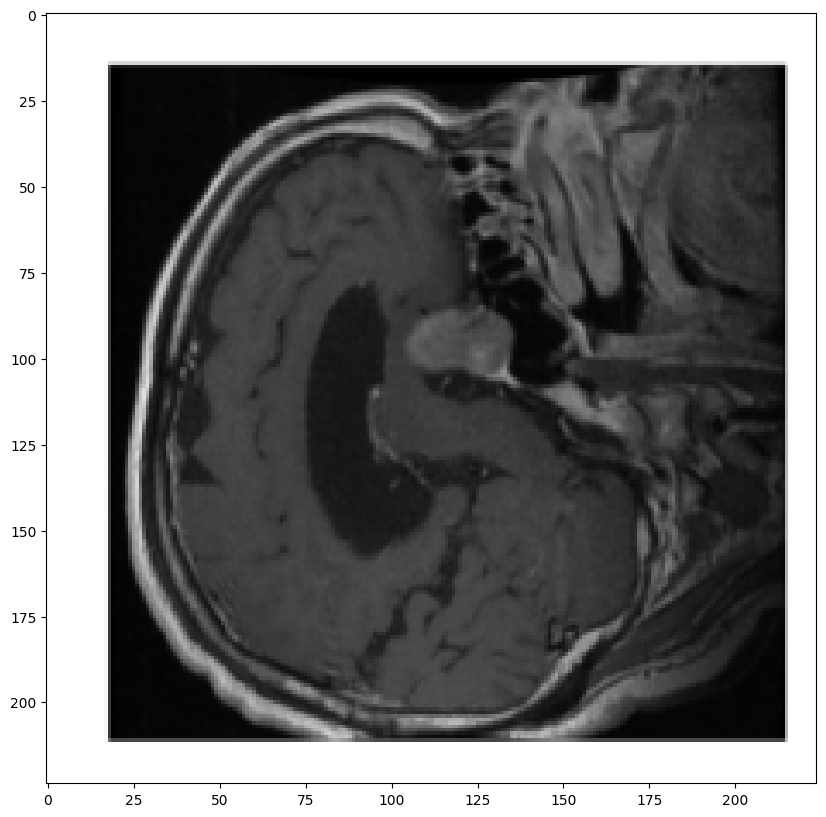

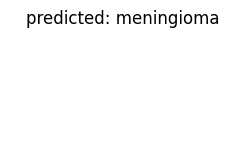

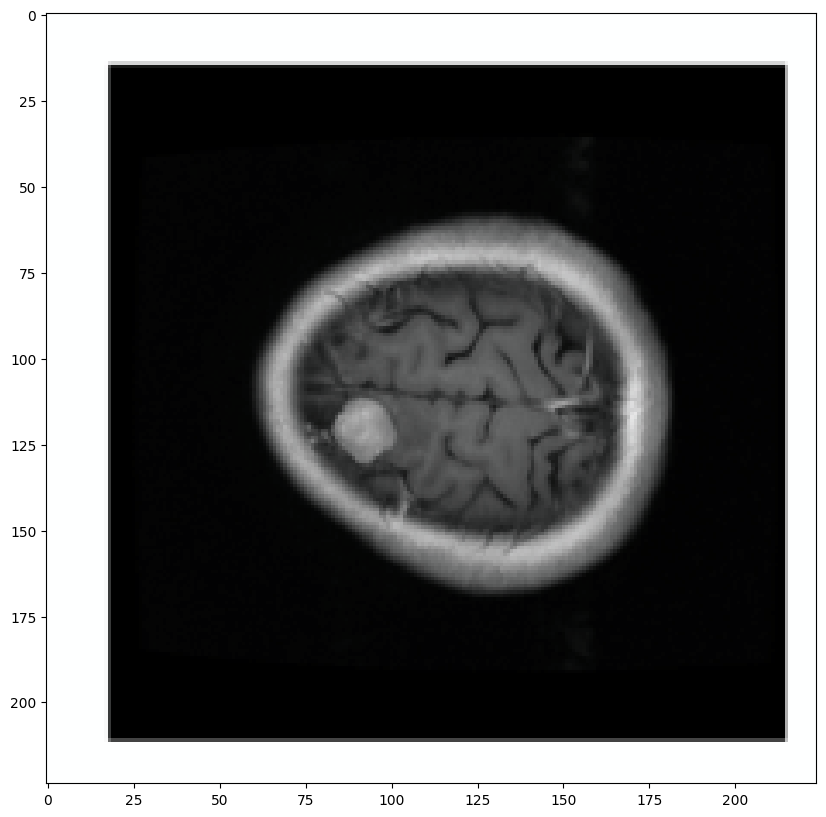

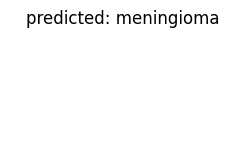

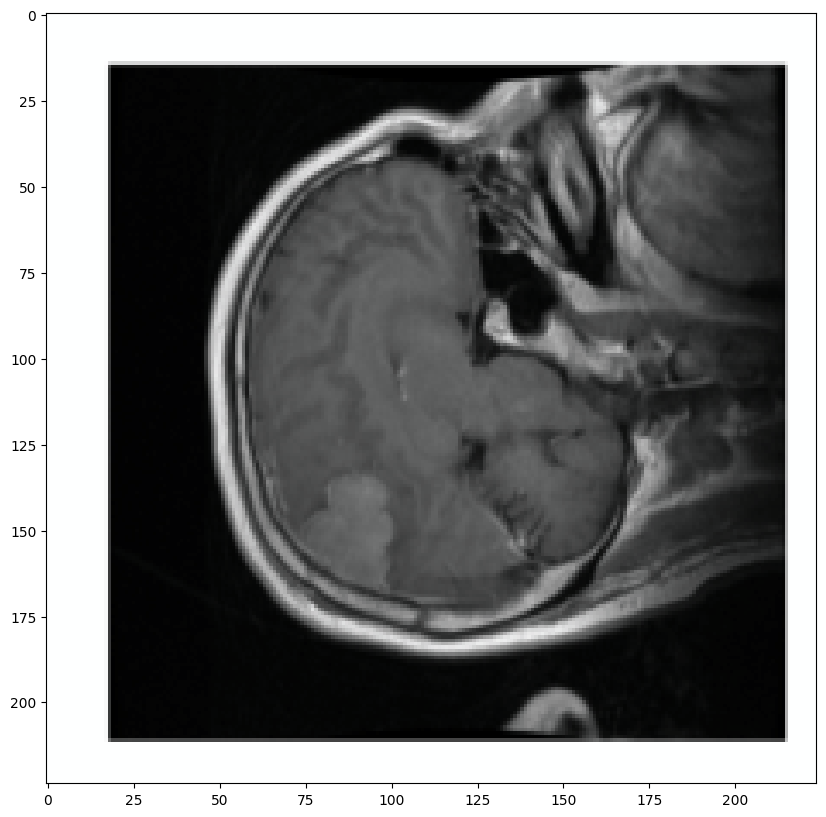

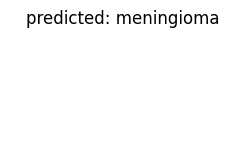

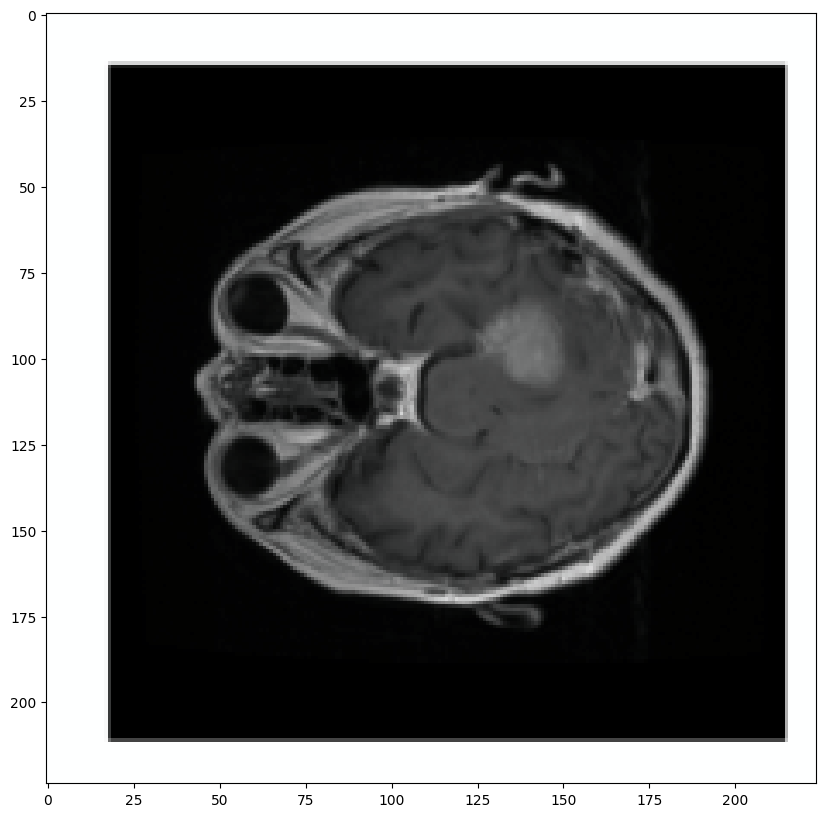

In [43]:
visualize_model(model_ft)

In [44]:
# save the trained resnet model's state dictionary
torch.save(model_ft.state_dict(), 'resnet_model.pth')

In [45]:
# load the trained model
model_ft.load_state_dict(torch.load('/content/resnet_model.pth'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
correct = 0
total = 0
res_labels = []
res_preds = []
res_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        res_labels.extend(labels.cpu().numpy())
        res_preds.extend(preds.cpu().numpy())
        res_probs.extend(outputs.cpu().numpy())

accuracy = correct / total
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9820846905537459


The Resnet has an test accuracy of 97%

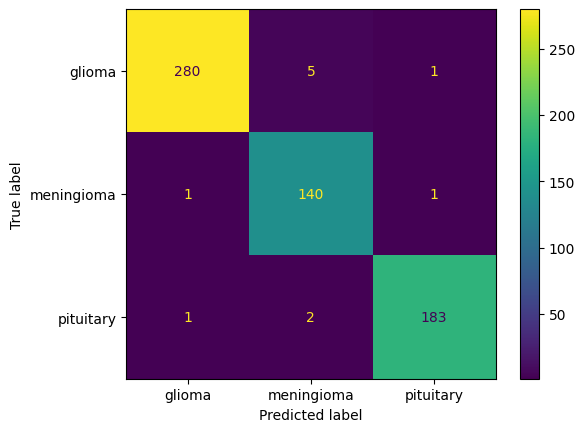

In [47]:
cm = confusion_matrix(res_labels, res_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [48]:
# classification report of the resnet
report = classification_report(res_labels, res_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       286
  meningioma       0.95      0.99      0.97       142
   pituitary       0.99      0.98      0.99       186

    accuracy                           0.98       614
   macro avg       0.98      0.98      0.98       614
weighted avg       0.98      0.98      0.98       614



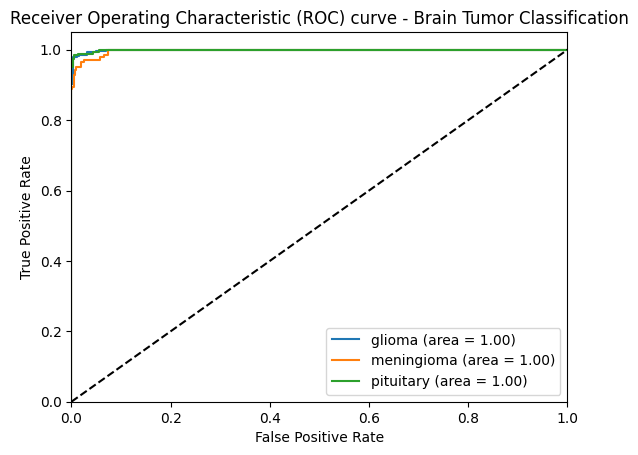

In [49]:
# initialising dictionaries
# false positive rate (FPR)
fpr = {}

# True Positive Rate (TPR)
tpr = {}

# ROC AUC values for each class
roc_auc = {}


# convert all the labels and probabilities to numpy arrays
rest_labels = np.array(res_labels)
rest_probs = np.array(res_probs)

# calculate the FPR, TPR, ROC AUC for each class
for i in range(3):

  # compute ROC curve for each class
    fpr[i], tpr[i], _ = roc_curve(rest_labels == i, rest_probs[:, i])

    # compute area under the curve
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for all the classes
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

# plot a diagonal line representing a random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--')

# set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve - Brain Tumor Classification')
plt.legend(loc='lower right')
plt.show()



##3.3 Tumor Segmentation Using the U-Net

#### Data preparation

In [50]:
train_dir = '/content/drive/My Drive/train_test_dataset_with_masks/train'
test_dir = '/content/drive/My Drive/train_test_dataset_with_masks/test'

In [73]:
# braintumordataset extends the torch.utils.data.Dataset class
# handles preprocessing brain tumor images and their corresponding masks
# for loading into a pytorch model

class BrainTumorDataset(Dataset):
  def __init__(self, images, masks, transform=None):
    self.images = images
    self.masks = masks
    self.transform = transform


# returns the number of images present in that folder
  def __len__(self):
    return len(self.images)

    # retrives a single image and it's mask
  def __getitem__(self, idx):
    image = self.images[idx]
    mask = self.masks[idx]

    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented['image']
      mask = augmented['mask']

    image = np.expand_dims(image, axis=0)
    mask = np.expand_dims(mask, axis=0)

    return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


def load_images_and_masks(directory):
  images = []
  masks = []

  # list the class directories
  class_dirs = sorted(os.listdir(directory))
  print(f"Found classes: {class_dirs}")



  for class_dir in class_dirs:
    image_dir = os.path.join(directory, class_dir, 'images')
    mask_dir = os.path.join(directory, class_dir, 'masks')


    # list the files in the image and mask directories
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    print(f"Processing {class_dir} with {len(image_files)} images and {len(mask_files)} masks")

      # Load the images and masks
    for image_file in image_files:
      mask_file = image_file.replace('.png', '_mask.png')

      if mask_file in mask_files:
          image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
          mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

          image = cv2.resize(image, (128, 128))  # Resize if necessary
          mask = cv2.resize(mask, (128, 128))

          images.append(image)
          masks.append(mask)

    images = np.array(images).astype('float32') / 255.0
    masks = np.array(masks).astype('float32') / 255.0
    # masks = np.expand_dims(masks, axis=-1)  # Add a channel dimension
    print(f"Loaded {len(images)} images and {len(masks)} masks")

    return images, masks

# Load training and testing data
train_images, train_masks = load_images_and_masks(train_dir)
test_images, test_masks = load_images_and_masks(test_dir)

# Split the training set into a training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)



# creating datasets
train_dataset = BrainTumorDataset(X_train, Y_train)
val_dataset = BrainTumorDataset(X_val, Y_val)
test_dataset = BrainTumorDataset(test_images, test_masks)

# creating the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Found classes: ['glioma', 'meningioma', 'pituitary']
Processing glioma with 1140 images and 1140 masks
Loaded 1140 images and 1140 masks
Found classes: ['glioma', 'meningioma', 'pituitary']
Processing glioma with 286 images and 286 masks
Loaded 286 images and 286 masks


Train images shape: (1140, 128, 128), Train masks shape: (1140, 128, 128)
Test images shape: (286, 128, 128), Test masks shape: (286, 128, 128)


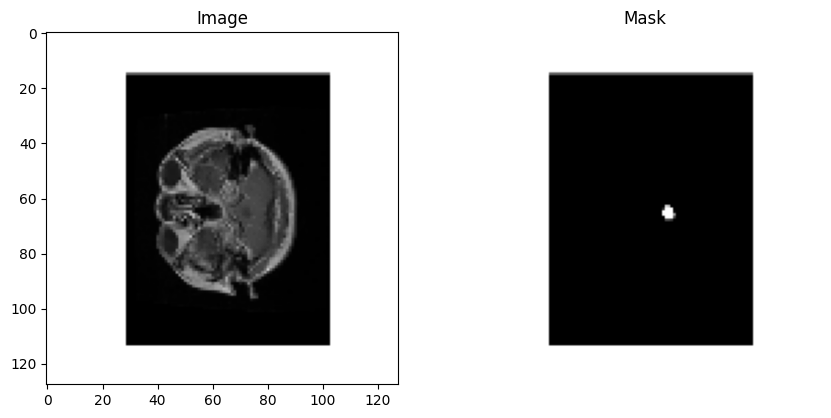

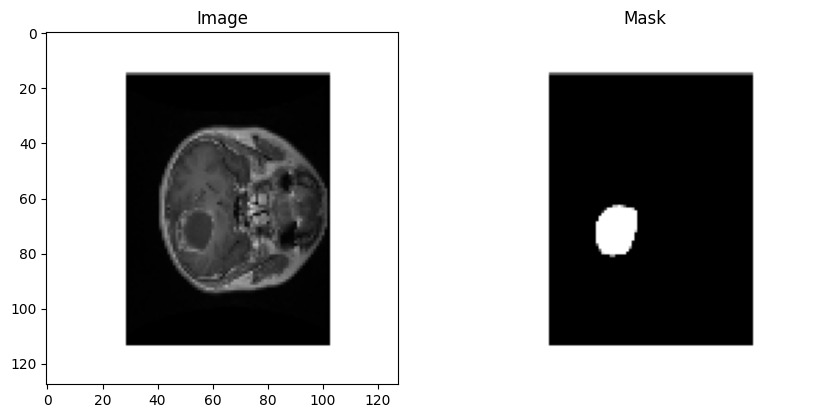

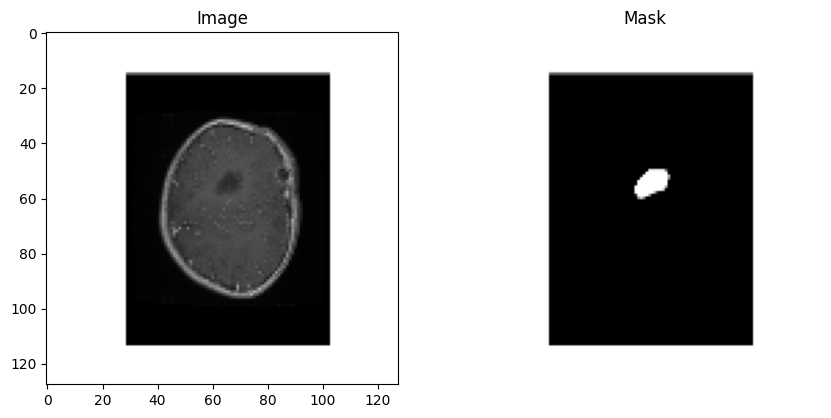

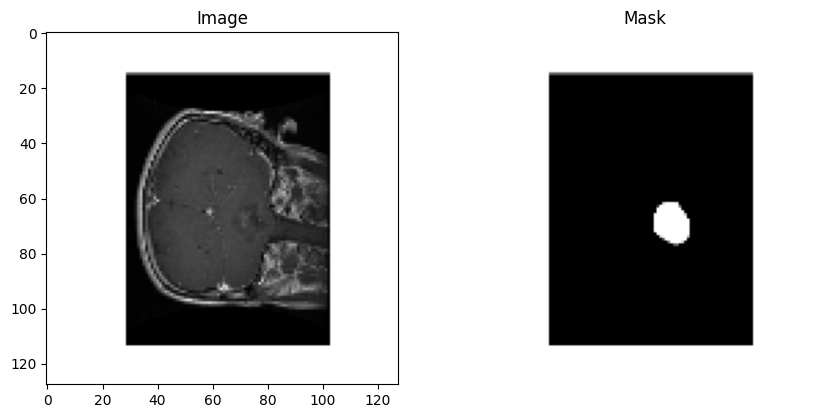

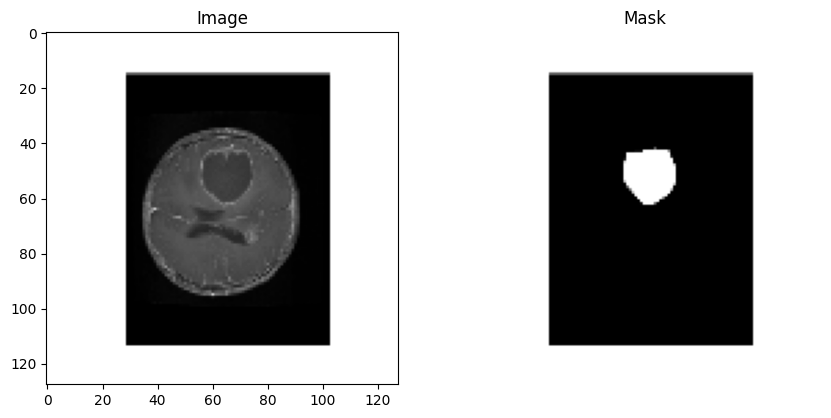

In [75]:
# Print some statistics
print(f'Train images shape: {train_images.shape}, Train masks shape: {train_masks.shape}')
print(f'Test images shape: {test_images.shape}, Test masks shape: {test_masks.shape}')

# Display a few images and masks to verify
import numpy as np
import matplotlib.pyplot as plt

# Function to show image and mask samples
def show_sample(images, masks, idx):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title('Image')
    plt.subplot(1, 2, 2)
    plt.imshow(masks[idx], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

# Show random samples from training data
num_samples = 5
indices = np.random.randint(0, len(train_images), num_samples)
for idx in indices:
    show_sample(train_images, train_masks, idx)


### Defining the U-Net Model

In [79]:
import torch
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # Adding Batch Normalization
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # Adding Batch Normalization
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR2d(1, 64)
        self.enc2 = CBR2d(64, 128)
        self.enc3 = CBR2d(128, 256)
        self.enc4 = CBR2d(256, 512)
        self.enc5 = CBR2d(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR2d(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR2d(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR2d(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR2d(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv_last(dec1))

# Initialize the model
model = UNet()


### Defining loss function and optimizer

In [80]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return model, train_losses, val_losses

# Train the model
num_epochs = 50
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/50, Training Loss: 0.2491, Validation Loss: 0.1266
Epoch 2/50, Training Loss: 0.1026, Validation Loss: 0.0842
Epoch 3/50, Training Loss: 0.0794, Validation Loss: 0.0705
Epoch 4/50, Training Loss: 0.0686, Validation Loss: 0.0631
Epoch 5/50, Training Loss: 0.0624, Validation Loss: 0.0581
Epoch 6/50, Training Loss: 0.0584, Validation Loss: 0.0549
Epoch 7/50, Training Loss: 0.0555, Validation Loss: 0.0526
Epoch 8/50, Training Loss: 0.0533, Validation Loss: 0.0506
Epoch 9/50, Training Loss: 0.0516, Validation Loss: 0.0492
Epoch 10/50, Training Loss: 0.0502, Validation Loss: 0.0479
Epoch 11/50, Training Loss: 0.0490, Validation Loss: 0.0469
Epoch 12/50, Training Loss: 0.0480, Validation Loss: 0.0460
Epoch 13/50, Training Loss: 0.0471, Validation Loss: 0.0452
Epoch 14/50, Training Loss: 0.0463, Validation Loss: 0.0445
Epoch 15/50, Training Loss: 0.0455, Validation Loss: 0.0439
Epoch 16/50, Training Loss: 0.0448, Validation Loss: 0.0432
Epoch 17/50, Training Loss: 0.0441, Validation Lo

### Training and Validation

Epoch 1/30, Training Loss: 0.0935, Validation Loss: 0.0908, Training Accuracy: 0.9840, Validation Accuracy: 0.9843
Epoch 2/30, Training Loss: 0.0894, Validation Loss: 0.0869, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 3/30, Training Loss: 0.0858, Validation Loss: 0.0834, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 4/30, Training Loss: 0.0825, Validation Loss: 0.0803, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 5/30, Training Loss: 0.0796, Validation Loss: 0.0775, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 6/30, Training Loss: 0.0770, Validation Loss: 0.0751, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 7/30, Training Loss: 0.0747, Validation Loss: 0.0729, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 8/30, Training Loss: 0.0727, Validation Loss: 0.0710, Training Accuracy: 0.9841, Validation Accuracy: 0.9844
Epoch 9/30, Training Loss: 0.0710, Validation Loss: 0.0694, Training Accuracy: 0

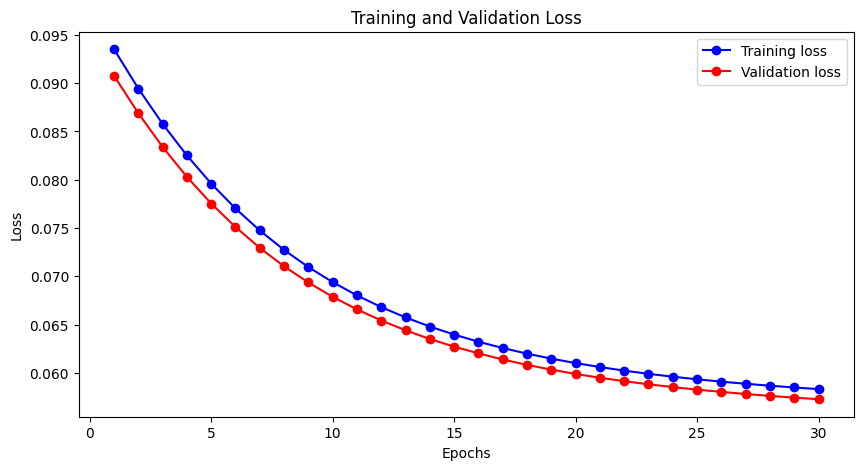

In [67]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == masks).sum().item()
            total_train += masks.numel()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0.5).float()
                correct_val += (predicted == masks).sum().item()
                total_val += masks.numel()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 30
trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot training and validation loss and accuracy curves
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the loss curves
plot_loss_curves(train_losses, val_losses)



Model Evaluation

In [65]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.cuda()

            outputs = model(images)
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Evaluate the trained model
evaluate_model(trained_model, test_loader)


Test Loss: 0.0959


In [1]:
def plot_results(model, test_loader, num_images=5, threshold=0.5):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    axes = axes.flatten()

    for i, (images, masks) in enumerate(test_loader):
        if i >= num_images:
            break

        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)

        # Get the first image in the batch
        image = images[0].cpu().numpy().squeeze()
        mask = masks[0].cpu().numpy().squeeze()
        output = outputs[0].cpu().numpy().squeeze()

        # Apply threshold to the output
        output = (output > threshold).astype(np.uint8)

        # Plot original image
        ax = axes[i * 3]
        ax.imshow(image, cmap='gray')
        ax.set_title("Original Image")
        ax.axis('off')

        # Plot ground truth mask
        ax = axes[i * 3 + 1]
        ax.imshow(mask, cmap='gray')
        ax.set_title("Original Mask")
        ax.axis('off')

        # Plot predicted mask
        ax = axes[i * 3 + 2]
        ax.imshow(output, cmap='gray')
        ax.set_title("Predicted Mask")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_results(trained_model, test_loader, num_images=5)


NameError: name 'trained_model' is not defined

In [ ]:
# saving the model
torch.save(trained_model.state_dict(), 'unet_brain_tumor_segmentation.pth')
